# Project 4

## Random walking dead


## Group 1 9:

- Mussa Banjai
- Tapas Dev
- Jason Kapka
- Taz Ahmed

## Introduction



## Abstract



## Libraries

In [37]:
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import math as m
import scipy as sp
from scipy import optimize
import pandas as pd
import scipy.integrate

from enum import Enum # Importing the enum

# Directions

In [38]:
class Direction(Enum):

    EAST = 1
    NORTH = 2
    WEST = 3
    SOUTH = 4

## Disease State

In [39]:
class DiseaseState(Enum):

    HUMAN = 0 # SUSCEPTIBLE = HUMAN
    EXPOSED = 1
    ZOMBIE = 2 #INFECTIOUS = ZOMBIE
    IMMUNE = 3
    DEAD = 4

## Random Walk Epidemic Simulator class

In [51]:
class RandomWalkEpidemicSimulator:
    """
    Class used to model the spreading of a contagious disease in a
    population of individuals with a 2D random walk.

    Each walker has a disease state which is represented by an
    integer Enum. Also, a set of integer (x, y)-coordinates are
    stored for each walker. The possible coordinates are:

        {0, 1, ..., Lx-1} in the x-direction
        {0, 1, ..., Ly-1} in the y-direction

    It is only possible to move North, South, East, or West. If a
    walker attempts to move outside of the physical domain, nothing
    happens (i.e., a "bounce-back boundary condition" is enforced).
    """
    def __init__(self,
                 population_size,
                 no_initially_infected=1,
                 nx=50,
                 ny=50,
                 q=0.9,
                 p = 0.0,
                 gameshow=False):
        """
        :param population_size: The total number of people (N).
        :param no_init_infected: The number of infected people at t=0.
        :param nx: The number of lattice nodes in the x-direction
        :param ny: The number of lattice nodes in the y-direction.
        :param q: The probability of infection (0 <= q <= 1).
        :param p: The probability of death (0 <= p <= 1).
        :gameshow: It enables/disables the graph of the walkers.
        """
        self.N_ = population_size
        self.Z0_= no_initially_infected # No. of Zombies that are starting
        self.nx_= nx
        self.ny_= ny
        self.infection_probability_ = q
        self.death_probability_ = p
        self.gameshow = gameshow


        self.Walkers_ = np.random.randint(0, [self.nx_, self.ny_], size=(self.N_, 2))
        self.Walkers_Old_ = self.Walkers_.copy() # in case any move is illegall, we have a old steps

        # First, let all walkers be in the susceptible compartment:
        self.State_ = np.full(self.N_, DiseaseState.HUMAN.value)
        # Next, change walker number 0, 1, 2, ..., I0-1 to be infectious:
        self.State_[0:self.Z0_] = DiseaseState.ZOMBIE.value

        # Records
        self.record_humans = np.array([])
        self.record_zombies = np.array([])
        self.record_deads = np.array([])

        

    def move(self):
        """
        This function allows the walkers to change their position
        """
        
        proposed_directions=np.random.randint(0,4,size=self.N_) #The directions will be choosen randomly for all the walkers.
        
        # Directions
        move_east = (proposed_directions == Direction.EAST.value)
        move_north = (proposed_directions == Direction.NORTH.value)
        move_west = (proposed_directions == Direction.WEST.value)
        move_south = (proposed_directions == Direction.SOUTH.value)

        # This will only allow Walkers that are not dead to walk
        not_dead = (self.State_ != DiseaseState.DEAD.value)


        self.Walkers_[move_east & not_dead] += [1, 0]
        self.Walkers_[move_north & not_dead] += [0, 1]
        self.Walkers_[move_west & not_dead] -= [1, 0]
        self.Walkers_[move_south & not_dead] -= [0, 1]


    def is_at_illegal_position(self):
        """
        Checks if it is out of position
        """
        wrong_x=np.logical_or(self.Walkers_[:,0]<0,self.Walkers_[:,0]>=self.nx_)
        wrong_y=np.logical_or(self.Walkers_[:,1]<0,self.Walkers_[:,1]>=self.ny_)
        wrong_xy=np.logical_or(wrong_x,wrong_y)
        self.Walkers_[wrong_xy]=self.Walkers_Old_[wrong_xy]
        
        self.Walkers_Old_=np.copy(self.Walkers_)


    def collide_extremely_slowly(self): # note: class (instance) function
        '''
        Note: SUSCEPTIBLE = HUMAN, and INFECTIOUS = ZOMBIE
        This code is so slow that it will be impractical to use in the full project.
        You can use it to test your code. HINT: Try to use np.logical_and to find humans
        at	the same place as zombies, instead of the loop: for walker_idx in range(self.N_):
        '''

        # Get (x,y)-coordinates of susceptibles & infectious people
        S_coord = self.Walkers_[self.State_== DiseaseState.HUMAN.value]
        I_coord = self.Walkers_[self.State_ == DiseaseState.ZOMBIE.value]

        no_infected = len(I_coord)
        for infected_idx in range(no_infected):
            for walker_idx in range(self.N_):
                walker_is_susceptible = (self.State_[walker_idx] == DiseaseState.HUMAN.value)
                infected_at_same_location = np.all(I_coord[infected_idx] == self.Walkers_[walker_idx])
                
                if walker_is_susceptible and infected_at_same_location:
                    q = np.random.uniform(0, 1)
                    if q < self.infection_probability_:
                        self.State_[walker_idx] = DiseaseState.ZOMBIE.value

    def collide_much_much_faster(self):
        '''
        Calculates interaction between Zombies and Walkers (class implementation)
        '''
        Z_coord = self.Walkers_[self.State_ == DiseaseState.ZOMBIE.value]
        for infected_idx in Z_coord: # loop over all zombies
            # compare x and y coordinate of one zombie and all Walkers to
            # find which are in the same place
            infected_at_same_location_xy = np.logical_and(infected_idx[0]==self.Walkers_[:,0],infected_idx[1]==self.Walkers_[:,1])
            
            # infected_at_same_location_xy contains a list of True/False of all
            # Walkers at the same/not the same place (both Humans and Zombies)
            # get the index to the Walkers, needed to update state (note the [0] at the end)
            id_walkers_at_same_location = np.where(infected_at_same_location_xy)[0]
            for walkers_id in id_walkers_at_same_location:
                if self.State_[walkers_id] == DiseaseState.HUMAN.value:
                    q = np.random.uniform(0, 1)
                    if q < self.infection_probability_:
                        self.State_[walkers_id] = DiseaseState.ZOMBIE.value

    def check_if_zombies_dies(self):

        # Find the index of the Zombies
        # Loop through it 
        zombies_idx = np.where(self.State_ == DiseaseState.ZOMBIE.value)
        for idx in zombies_idx: # loop over all zombies
                p = np.random.uniform(0, 1)
                if p < self.death_probability_:
                    self.State_[idx] = DiseaseState.DEAD.value

                

    def game(self):
        Z_coord= self.Walkers_[self.State_== DiseaseState.ZOMBIE.value]
        H_coord= self.Walkers_[self.State_==DiseaseState.HUMAN.value]
        D_coord = self.Walkers_[self.State_==DiseaseState.DEAD.value]
        plt.scatter(Z_coord[:,0],Z_coord[:,1],s=80,c='r')
        plt.scatter(H_coord[:,0],H_coord[:,1],c='b')
        plt.scatter(D_coord[:,0],D_coord[:,1], marker='s', c='y')
        plt.xlim(0,self.nx_)
        plt.ylim(0,self.ny_)
        plt.grid()
        plt.show()

    def record(self):
        no_susceptible = np.sum(self.State_ == DiseaseState.HUMAN.value)
        no_infectious = np.sum(self.State_ == DiseaseState.ZOMBIE.value)
        no_recovered = np.sum(self.State_ == DiseaseState.DEAD.value)

        self.record_humans = np.append(self.record_humans, no_susceptible)
        self.record_zombies = np.append(self.record_zombies, no_infectious)
        self.record_deads = np.append(self.record_deads, no_recovered)
        
    
    def run(self, steps):
        for s in range(steps):
            if self.gameshow == True:
                self.game()
            self.record()
            self.move()
            self.is_at_illegal_position()
            self.collide_much_much_faster()
            self.check_if_zombies_dies()


    def stats(self):
        """
        It shows the statistics of humans, zombies and deaths
        """
        new_line = "\n"

        no_susceptible = np.sum(self.State_ == DiseaseState.HUMAN.value)
        no_infectious = np.sum(self.State_ == DiseaseState.ZOMBIE.value)
        no_recovered = np.sum(self.State_ == DiseaseState.DEAD.value)

        print(f"Susceptibles: {no_susceptible}{new_line}Infectious: {no_infectious}{new_line}Recovered: {no_recovered}")

# Exercises

## Exercise 1: Random walk SZ-model

Check the class

In [103]:
def record_humans_zombies_deads(simulations, timesteps, z_init, p = 0.0, N = 683):
    Record_Array_Humans = []
    Record_Array_Zombies = []
    Record_Array_Deads = []

    for n in range(simulations): # run n simulations
        r683 = RandomWalkEpidemicSimulator(N, z_init, 50, 50, 0.9, p)
        r683.run(timesteps)
        Record_Array_Humans.append(r683.record_humans)
        Record_Array_Zombies.append(r683.record_zombies)
        Record_Array_Deads.append(r683.record_deads)
    Record_Array_Humans = np.array(Record_Array_Humans)
    Record_Array_Zombies = np.array(Record_Array_Zombies)
    Record_Array_Deads = np.array(Record_Array_Deads)

    return Record_Array_Humans, Record_Array_Zombies, Record_Array_Deads

In [42]:
def plot_humans_zombies(record_humans, record_zombies):
    hx = np.arange(np.shape(record_humans)[1])
    hmean = np.mean(record_humans, 0) # Mean
    hstd = np.std(record_humans, 0) # Standard Deviation

    zx = np.arange(np.shape(record_zombies)[1])
    zmean = np.mean(record_zombies, 0) # Mean
    zstd = np.std(record_zombies, 0) # Standard Deviation

    plt.title(f"")

    plt.plot(hx, hmean, color = "blue", linestyle = "--", label = "Susceptible - RW") # plot the mean
    plt.fill_between(hx, hmean - hstd, hmean + hstd, color='grey', alpha=0.5)

    plt.plot(zx, zmean, color = "red", linestyle = "--", label = "Infected - RW") # plot the mean
    plt.fill_between(zx, zmean - zstd, zmean + zstd, color='grey', alpha=0.5)

    plt.legend()
    plt.grid()

### Question 1


In [129]:
h, z, r = record_humans_zombies_deads(10, 400, 1)

In [127]:
plot_humans_zombies(h, z)

NameError: name 'h' is not defined

**Answer:**

### Question 2


In [ ]:
h10, z10, r10 = record_humans_zombies_deads(100, 300, 10)

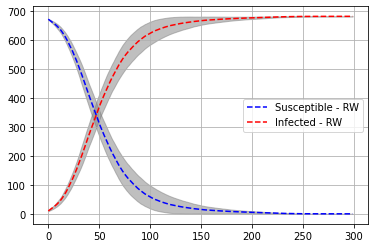

In [ ]:
plot_humans_zombies(h10, z10)

**Answer:**

<!---->

## Exercise 2: Compare random walk and ODE-based models

In [ ]:
class ODE:
    def __init__(
            self,
            N,
            Z_init,
            Sn,
            Zn,
            Rn,
            time = 300
            ):

        self.time = np.arange(time)

        self.N = N
        self.Z_init = Z_init

        self.Zn = Zn[:, 1:]

        self.Sn = Sn[:, 1:]
        self.Sn_1 = Sn[:, :-1]

        self.Rn = Rn[:, 1:]
        self.Rn_1 = Rn[:, :-1]

        self.beta = - ((self.Sn - self.Sn_1)*self.N) / ((self.Sn+1)*self.Zn)
        self.betamedian = np.median(self.beta) # median for the beta
        self.betamean = np.mean(self.beta) # mean for the beta

        self.tau = (self.Rn - self.Rn_1)/(self.Zn)
        self.taumean = np.mean(self.tau) # mean for the tau


    def Z(self, t):
        S0 = self.N - self.Z_init
        Z0 = self.Z_init

        return self.N / (1 + (S0/Z0)*np.exp(-self.betamean*t))

    def dR(self, t):
        return (1/self.taumean + 1) * self.Z(t)

    def plot(self):
        plt.plot(self.time, self.Z(self.time), label = "Zombies - ODE")
        plt.plot(self.time, self.N / (1 + ((self.N - self.Z_init)/self.Z_init)*np.exp(-0.03854905883052674*self.time)), label = "Zombies - ODE, Beta = 0.038549058830526744")
        plt.plot(self.time, self.N / (1 + ((self.N - self.Z_init)/self.Z_init)*np.exp(-0.04*self.time)), label = "Zombies - ODE, Beta = 0.04")
        plt.plot(self.time, self.N / (1 + ((self.N - self.Z_init)/self.Z_init)*np.exp(-0.05*self.time)), label = "Zombies - ODE, Beta = 0.05")
        #plt.plot(self.time, self.N / (1 + ((self.N - self.Z_init)/self.Z_init)*np.exp(-0.055*self.time)), label = "Zombies - ODE, Beta = 0.055")
        plt.plot(self.time, self.N / (1 + ((self.N - self.Z_init)/self.Z_init)*np.exp(-0.072603571734108*self.time)), label = "Zombies - ODE, Beta = 0.072603571734108")
        plt.plot(self.time, self.N / (1 + ((self.N - self.Z_init)/self.Z_init)*np.exp(-0.07819904557342489*self.time)), label = "Zombies - ODE, Beta = 0.07819904557342489")

    def plot_R(self):
        plt.plot(self.time, self.dR(self.time), label = "Dead - ODE")

    def print_betamean(self):
        return self.betamean

    def print_beta(self):
        return self.beta

    def print_betamedian(self):
        return self.betamedian

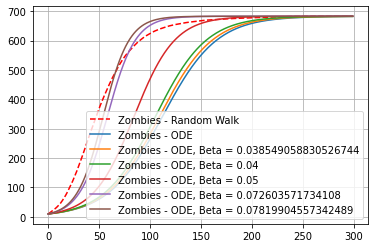

In [ ]:
zx_10 = np.arange(np.shape(z10)[1])
zmean_10 = np.mean(z10, 0) # Mean

ode = ODE(683, 10, h10, z10, r10)
plt.plot(zx_10, zmean_10, color = "red", linestyle = "--", label = "Zombies - Random Walk") # plot the random walk
ode.plot() # plot the analytical
plt.legend()
plt.grid()

0.03754905883052674
0.0
(100, 299)


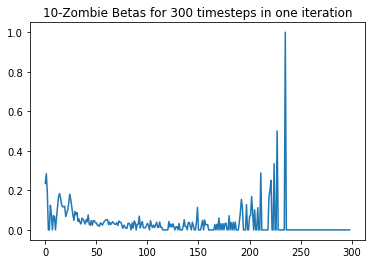

mean of betas between 1:240=0.04388151751226949
mean of betas between 40:60=0.05454539208788384
mean of betas between 0:75=0.072603571734108
mean of betas between 0:60=0.07819904557342489


In [ ]:
print(ode.print_betamean())
print(ode.print_betamedian())
#print(ode.print_beta())

print(np.shape(ode.print_beta()))
np.arange(100)

#plt.plot(np.arange(100), ode.print_beta())
plt.plot(np.arange(299), ode.print_beta()[1,:])
plt.title("10-Zombie Betas for 300 timesteps in one iteration")
plt.show()


print(f"mean of betas between 1:240={np.mean(ode.print_beta()[:,0:240])}")

print(f"mean of betas between 40:60={np.mean(ode.print_beta()[:,40:60])}")

print(f"mean of betas between 0:75={np.mean(ode.print_beta()[:,0:75])}")

print(f"mean of betas between 0:60={np.mean(ode.print_beta()[:,0:60])}")

#print(ode.print_beta())

[0.1998528475155303, 0.17456868011119808, 0.16429131841673722, 0.15628549433617156, 0.14604008809834537, 0.13979757996451217, 0.13641874241127436, 0.13173752097961955, 0.12842238159165045, 0.12556345866275043, 0.12272547155042998, 0.11979797148500339, 0.11837773879816196, 0.11691375400432136, 0.11544039652836136, 0.11379183609565573, 0.11233512742534159, 0.11107008597837308, 0.10982078864016873, 0.10878836434317554, 0.10733974741120689, 0.10610780171395268, 0.10496786884474679, 0.10378716899894586, 0.10280860921039807, 0.10167335998070338, 0.10067070078979241, 0.09961779365998101, 0.09872370394016085, 0.09770008776926682, 0.09681998038240133, 0.09604646226961909, 0.09519028879278527, 0.09436006532001673, 0.0936561658173445, 0.09283341020444709, 0.0921771011662034, 0.09143830135290994, 0.09070378944465614, 0.09002587231619544, 0.08925711007303243, 0.08851112212771291, 0.08778844135433564, 0.0870755586825761, 0.08641302542909945, 0.08574296708315886, 0.08513950136771234, 0.08464604212337

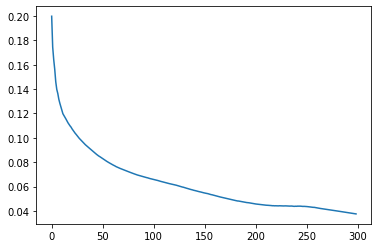

In [ ]:
betameans = []
for i in range(299):
    #print(np.mean(ode.print_beta()[:,0:i+1]))
    betameans.append(np.mean(ode.print_beta()[:,0:i+1]))
print(betameans)
#print(np.arange(299))
plt.plot(np.arange(299),betameans)
for i in range(225, 250):
    print(betameans[i])

[0.16939484126984128, 0.16939484126984128, 0.16939484126984128, 0.1542921686746988, 0.14068937105190882, 0.13014965606990148, 0.1278068862275449, 0.12361990950226244, 0.12027294739159146, 0.11550820226619313, 0.1129058992168269, 0.10811238622872972, 0.10799143923176419, 0.1059854159729427, 0.10391309639727361, 0.10286144578313253, 0.10122017487526552, 0.09911838333998477, 0.09820743865030675, 0.09710532302092811, 0.09555387671731162, 0.09483476811996668, 0.09308981872700013, 0.0922598946373092, 0.0922598946373092, 0.09125221283275994, 0.0904086980520607, 0.08970023785376219, 0.08851203043184692, 0.08695320059072159, 0.08618296529968454, 0.08568023584018064, 0.08469742063492064, 0.08417895731481861, 0.08346912172071044, 0.08291350531107738, 0.08218222072483997, 0.08145497912939774, 0.08039086233972531, 0.07968421871354125, 0.07904388916912283, 0.07831083740753217, 0.0778387900969883, 0.07738646020205835, 0.07663967708530989, 0.07601652156707558, 0.07541197795423388, 0.07482774480791575,

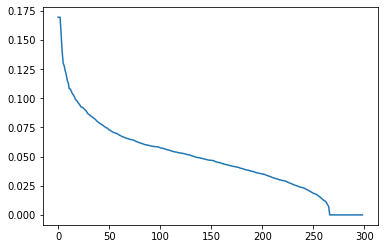

In [ ]:
betamedians = []
for i in range(299):
    #print(np.mean(ode.print_beta()[:,0:i+1]))
    betamedians.append(np.median(ode.print_beta()[:,0:i+1]))
print(betamedians)
#print(np.arange(299))
plt.plot(np.arange(299),betamedians)
for i in range(225, 250):
    print(betamedians[i])
print(f"mean of medians={np.mean(betamedians)}")
print(f"mean of medians 1:260={np.mean(betamedians[:260])}")

### Question 1

**Answer:**

## Exercise 3: Scenario what happens in Sokndal and Dirdal?

Check the class

**Sokndal**

In [ ]:
sokndal = RandomWalkEpidemicSimulator(683, 10, p=1/24)
sokndal.run(48)
sokndal.stats()

Susceptibles: 507
Infectious: 0
Recovered: 176


**Dirdal**

In [ ]:
dirdal = RandomWalkEpidemicSimulator(683, 10, p=1/48)
dirdal.run(48)
dirdal.stats()

Susceptibles: 609
Infectious: 0
Recovered: 74


In [ ]:
case_one_zombie = RandomWalkEpidemicSimulator(683, 1, p=0.0)

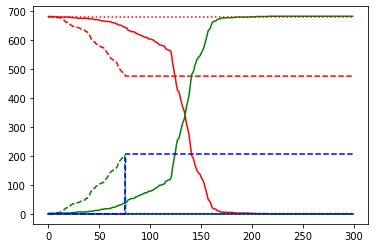

In [102]:
h1, z1, d1 = record_humans_zombies_deads(1, 300, 1, p=0.0)
h1s, z1s, d1s = record_humans_zombies_deads(1, 300, 1, p=1/24)
h1d, z1d, d1d = record_humans_zombies_deads(1, 300, 1, p=1/48)
#h10, z10, d10 = record_humans_zombies_deads(1, 300, 10, p=0.0)

plt.plot(np.arange(300), h1[0], c="r", ls="-")
plt.plot(np.arange(300), z1[0], c="g", ls="-")
plt.plot(np.arange(300), d1[0], c="b", ls="-")
plt.plot(np.arange(300), h1s[0], c="r", ls="--")
plt.plot(np.arange(300), z1s[0], c="g", ls="--")
plt.plot(np.arange(300), d1s[0], c="b", ls="--")
plt.plot(np.arange(300), h1d[0], c="r", ls=":")
plt.plot(np.arange(300), z1d[0], c="g", ls=":")
plt.plot(np.arange(300), d1d[0], c="b", ls=":")
#plt.plot(np.arange(300), h10[0], c="r")
#plt.plot(np.arange(300), z10[0], c="g")
#plt.plot(np.arange(300), d10[0], c="b")

In [ ]:
np.shape(np.arange(300))

(300,)

In [ ]:
np.shape(h1[0])

(300,)

### Question 1


**Answer:**

### Question 2


**Answer:**

## Exercise 4: Compare your results with SZR model

In [95]:
def plot_humans_zombies_deads(record_humans, record_zombies, record_deads):
    hx = np.arange(np.shape(record_humans)[1])
    hmean = np.mean(record_humans, 0) # Mean
    hstd = np.std(record_humans, 0) # Standard Deviation

    zx = np.arange(np.shape(record_zombies)[1])
    zmean = np.mean(record_zombies, 0) # Mean
    zstd = np.std(record_zombies, 0) # Standard Deviation

    rx = np.arange(np.shape(record_deads)[1])
    rmean = np.mean(record_deads, 0) # Mean
    rstd = np.std(record_deads, 0) # Standard Deviation

    plt.title(f"")

    plt.plot(hx, hmean, color = "blue", linestyle = "--", label = "Susceptible - RW") # plot the mean
    plt.fill_between(hx, hmean - hstd, hmean + hstd, color='grey', alpha=0.5)

    plt.plot(zx, zmean, color = "red", linestyle = "--", label = "Infected - RW") # plot the mean
    plt.fill_between(zx, zmean - zstd, zmean + zstd, color='grey', alpha=0.5)
    
    plt.plot(rx, rmean, color = "green", linestyle = "--", label = "Recovered - RW") # plot the mean
    plt.fill_between(rx, rmean - rstd, rmean + rstd, color='grey', alpha=0.5)


In [125]:
h4, z4, r4 = record_humans_zombies_deads(3, 1000, 1, 1/24)

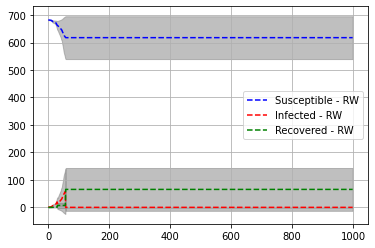

In [126]:
plot_humans_zombies_deads(h4, z4, r4)
plt.legend()
plt.grid()

C:\Users\Jason\AppData\Local\Temp/ipykernel_11020/1382847127.py:40: RuntimeWarning: divide by zero encountered in scalar divide
  return (1/self.taumean + 1) * self.Z(t)


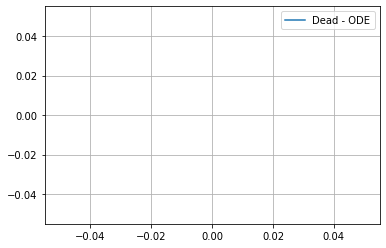

In [ ]:
hx_10 = np.arange(np.shape(h10)[1])
hmean_10 = np.mean(h10, 0) # Mean

ode = ODE(683, 10, h10, z10, r10)
#plt.plot(hx_10, hmean_10, color = "red", linestyle = "--", label = "Humans - Random Walk") # plot the random walk
ode.plot_R() # plot the analytical
plt.legend()
plt.grid()


In [ ]:
ode.tau

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## Exercise 5: Implement your own scenario

We decided to create a diferent file that will be dedicated to the own scenario. This decision was made because it does not affect the original Random Walk Class.
[Random Walk Dead - Own Scenario](RWD.ipynb)

## Reflections

### How did we work?
Basically, we worked on project in the group room, alongside with the lab classes which helped us a lot to discuss about the problems as well as finding the solution. We worked together even if any of us find any solution then we discussed about this and then came to a proper solution which looked like a good way of learning for us. Before finalizing any problem's solution, we together ended up with a good solution and agreed upon that.

Jason created some initial coding and worked on finding the solutions to the problem in theoretical matter. Taz and Tapas worked also on the theorectical matter proofs final Python code. Mussa wrote large sections of Python code and acted as Project Manager by compiling the individual contributions into a final product.


### What we did in the project?
We evaluated the analtical, numerical and line-source solution with two different boundary conditions and also found out the error between them by visuallizing the graphs. Then we matched our well test data from the provided file.

### Our Learnings?
We learnt the implementation of different numerical solvers for the radial deffusivity equation. We also learnt about PressureSolver Class. Besides, we also came across the learning of using two different boundary conditions. Although we did struggle in some stages but this project will help us in near future.future.


## Conclusion



## References

1) Aksel Hiorth. Computational Engineering and Modeling, 2021
   https://github.com/ahiorth/CompEngineering